# GREMLIN_TF v2.1
GREMLIN implemented in tensorflow

### Change log:
*   22Jan2018
 - moving [GREMLIN_TF_simple](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb) to a seperate notebook
*   19Jan2018
 - in the past we found that optimizing V first, required less iterations for convergence. Since V can be computed exactly (assuming no W), we replace this first optimization step with a simple V initialization.
 - a few variables were renamed to be consistent with the c++ version
*   16Jan2018
 - updating how indices are handled (for easier/cleaner parsing)
 - minor speed up in how we symmetrize and zero the diagional of W
*   15Jan2018
 - LBFGS optimizer replaced with a modified version of the ADAM optimizer
 - Added option for stochastic gradient descent (via batch_size)
  
### Method:
GREMLIN takes a multiple sequence alignment (MSA) and returns a Markov Random Field (MRF). The MRF consists of a one-body term (V) that encodes conservation, and a two-body term (W) that encodes co-evolution.

For more details about the method see:
[Google slides](https://docs.google.com/presentation/d/1aooxoksosSv7CWs9-ktqhUjyXR3wrgbG5a6PCr92od4/) and accompanying [Google colab](https://colab.research.google.com/drive/17RJcExuyifnd7ShTcsZGh6mBpWq0-s60)

See [GREMLIN_TF_simple](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb) for a stripped down version of this code (with no funky gap removal, sequence weight, etc). This is intented for educational purpose,  and could also be very useful for anyone trying to modify or improve the algorithm!


In [1]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

In [2]:
FASTAFILE = "1581003351.fas"

## libraries

In [3]:
%%capture
!pip install tensorflow==1.13.1

In [4]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from scipy import stats
from scipy.spatial.distance import pdist,squareform
import pandas as pd

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

In [5]:
from tensorflow.python.framework import ops

## Params

In [6]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
  a2n[a] = n
################

def aa2num(aa):
  '''convert aa into num'''
  if aa in a2n: return a2n[aa]
  else: return a2n['-']

## Functions for prepping the MSA (Multiple sequence alignment)

In [7]:
# from fasta
def parse_fasta(filename,limit=-1):
  '''function to parse fasta'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      if len(header) == limit:
        break
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)

def filt_gaps(msa,gap_cutoff=0.5):
  '''filters alignment to remove gappy positions'''
  tmp = np.zeros_like(msa)
  tmp[np.where(msa == 20)] = 1
  non_gaps = np.where(np.sum(tmp.T,-1).T/msa.shape[0] < gap_cutoff)[0]
  return msa[:,non_gaps],non_gaps

def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  ncol = msa.shape[1]
  
  # pairwise identity
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))

  # weight for each sequence
  msa_w = np.zeros_like(msa_sm)
  msa_w[np.where(msa_sm >= eff_cutoff)] = 1
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

def mk_msa(seqs):
  '''converts list of sequences to msa'''
  
  msa_ori = []
  for seq in seqs:
    msa_ori.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa_ori)
  
  # remove positions with more than > 50% gaps
  msa, v_idx = filt_gaps(msa_ori,0.5)
  
  # compute effective weight for each sequence
  msa_weights = get_eff(msa,0.8)

  # compute effective number of sequences
  ncol = msa.shape[1] # length of sequence
  w_idx = v_idx[np.stack(np.triu_indices(ncol,1),-1)]
  
  return {"msa_ori":msa_ori,
          "msa":msa,
          "weights":msa_weights,
          "neff":np.sum(msa_weights),
          "v_idx":v_idx,
          "w_idx":w_idx,
          "nrow":msa.shape[0],
          "ncol":ncol,
          "ncol_ori":msa_ori.shape[1]}


## GREMLIN

In [8]:
# external functions

def sym_w(w):
  '''symmetrize input matrix of shape (x,y,x,y)'''
  x = w.shape[0]
  w = w * np.reshape(1-np.eye(x),(x,1,x,1))
  w = w + tf.transpose(w,[2,3,0,1])
  return w

def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
  # adam optimizer
  # Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
  # with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
  # (b_fix=False) speeds up convergence for our case.
  
  if var_list is None: var_list = tf.trainable_variables() 
  gradients = tf.gradients(loss,var_list)
  if b_fix: t = tf.Variable(1.0,"t")
  opt = []
  for n,(x,g) in enumerate(zip(var_list,gradients)):
    if g is not None:
      ini = dict(initializer=tf.zeros_initializer,trainable=False)
      mt = tf.get_variable(name+"_mt_"+str(n),shape=x.shape, **ini)
      vt = tf.get_variable(name+"_vt_"+str(n),shape=(1,), **ini)
      
      mt_tmp = b1*mt+(1-b1)*g
      vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
      lr_tmp = lr/tf.sqrt(vt_tmp)

      if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

      opt.append(x.assign_add(-lr_tmp * mt_tmp))
      opt.append(vt.assign(vt_tmp))
      opt.append(mt.assign(mt_tmp))
        
  if b_fix: t.assign_add(1.0)
  return(tf.group(opt))

In [9]:
def GREMLIN(msa, opt_type="adam", opt_iter=100, opt_rate=1.0, batch_size=None):
  
  ##############################################################
  # SETUP COMPUTE GRAPH
  ##############################################################
  # kill any existing tensorflow graph
  # PG added 2020-01-30
  # tf.reset_default_graph()
  ops.reset_default_graph()
  
  ncol = msa["ncol"] # length of sequence

  # msa (multiple sequence alignment) 
  MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")
  
  # one-hot encode msa
  OH_MSA = tf.one_hot(MSA,states)
  
  # msa weights
  MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")
  
  # 1-body-term of the MRF
  V = tf.get_variable(name="V", 
                      shape=[ncol,states],
                      initializer=tf.zeros_initializer)

  # 2-body-term of the MRF
  W = tf.get_variable(name="W",
                      shape=[ncol,states,ncol,states],
                      initializer=tf.zeros_initializer)
  
  # symmetrize W
  W = sym_w(W)
  
  def L2(x): return tf.reduce_sum(tf.square(x))
  
  ########################################
  # V + W
  ########################################
  VW = V + tf.tensordot(OH_MSA,W,2)

  # hamiltonian
  H = tf.reduce_sum(tf.multiply(OH_MSA,VW),axis=2)
  # local Z (parition function)
  Z = tf.reduce_logsumexp(VW,axis=2)

  # Psuedo-Log-Likelihood
  PLL = tf.reduce_sum(H - Z, axis=1)

  # Regularization
  L2_V = 0.01 * L2(V)
  L2_W = 0.01 * L2(W) * 0.5 * (ncol-1) * (states-1)

  # loss function to minimize
  loss = -tf.reduce_sum(PLL*MSA_weights)/tf.reduce_sum(MSA_weights)
  loss = loss + (L2_V + L2_W)/msa["neff"]

  ##############################################################
  # MINIMIZE LOSS FUNCTION
  ##############################################################
  if opt_type == "adam":  
    opt = opt_adam(loss,"adam",lr=opt_rate)

  # generate input/feed
  def feed(feed_all=False):
    if batch_size is None or feed_all:
      return {MSA:msa["msa"], MSA_weights:msa["weights"]}
    else:
      idx = np.random.randint(0,msa["nrow"],size=batch_size)
      return {MSA:msa["msa"][idx], MSA_weights:msa["weights"][idx]}
  
  # optimize!
  with tf.Session() as sess:
    # initialize variables V and W
    sess.run(tf.global_variables_initializer())
    
    # initialize V
    msa_cat = tf.keras.utils.to_categorical(msa["msa"],states)
    pseudo_count = 0.01 * np.log(msa["neff"])
    V_ini = np.log(np.sum(msa_cat.T * msa["weights"],-1).T + pseudo_count)
    V_ini = V_ini - np.mean(V_ini,-1,keepdims=True)
    sess.run(V.assign(V_ini))
    
    # compute loss across all data
    get_loss = lambda: round(sess.run(loss,feed(feed_all=True)) * msa["neff"],2)
    print("starting",get_loss())
    
    if opt_type == "lbfgs":
      lbfgs = tf.contrib.opt.ScipyOptimizerInterface
      opt = lbfgs(loss,method="L-BFGS-B",options={'maxiter': opt_iter})
      opt.minimize(sess,feed(feed_all=True))
      
    if opt_type == "adam":
      for i in range(opt_iter):
        sess.run(opt,feed())  
        if (i+1) % int(opt_iter/10) == 0:
          print("iter",(i+1),get_loss())
    
    # save the V and W parameters of the MRF
    V_ = sess.run(V)
    W_ = sess.run(W)
    
  # only return upper-right triangle of matrix (since it's symmetric)
  tri = np.triu_indices(ncol,1)
  W_ = W_[tri[0],:,tri[1],:]
  
  mrf = {"v": V_,
         "w": W_,
         "v_idx": msa["v_idx"],
         "w_idx": msa["w_idx"]}
  
  return mrf

## EXAMPLE

In [10]:
# ===============================================================================
# PREP MSA
# ===============================================================================
# parse fasta
names, seqs = parse_fasta(FASTAFILE)
print("Alignment has been parsed!")
# process input sequences
msa = mk_msa(seqs)

Alignment has been parsed!


In [11]:
%%time
# ===============================================================================
# RUN GREMLIN
# ===============================================================================
# Note: the original GREMLIN uses the "lbfgs" optimizer which is EXTREMELY slow 
# in tensorflow. The modified adam optimizer is much faster, but may 
# require adjusting number of iterations (opt_iter) to converge to the same 
# solution. To switch back to the original, set opt_type="lbfgs".
# ===============================================================================
mrf = GREMLIN(msa)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
starting 9933557.78
iter 10 7032387.97
iter 20 6072971.19
iter 30 5573091.39
iter 40 5282837.81
iter 50 5104826.99
iter 60 4989305.67
iter 70 4911357.85
iter 80 4856954.23
iter 90 4818043.06
iter 100 4789698.35
CPU times: user 3h 21min 15s, sys: 14min 30s, total: 3h 35min 45s
Wall time: 3min 38s


## Explore the contact map
### Contact prediction:

For contact prediction, the W matrix is reduced from LxLx21x21 to LxL matrix (by taking the L2norm for each of the 20x20). In the code below, you can access this as mtx["raw"]. Further correction (average product correction) is then performed to the mtx["raw"] to remove the effects of entropy, mtx["apc"]. The relative ranking of mtx["apc"] is used to assess importance. When there are enough effective sequences (>1000), we find that the top 1.0L contacts are ~90% accurate! When the number of effective sequences is lower, NN can help clean noise and fill in missing contacts.


## Functions for extracting contacts from MRF

In [12]:
###################
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf):
  '''get mtx given mrf'''
  
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(mrf["w"][:,:-1,:-1]),(1,2)))
  raw_sq = squareform(raw)

  # apc (average product correction)
  ap_sq = np.sum(raw_sq,0,keepdims=True)*np.sum(raw_sq,1,keepdims=True)/np.sum(raw_sq)
  apc = squareform(raw_sq - ap_sq, checks=False)

  mtx = {"i": mrf["w_idx"][:,0],
         "j": mrf["w_idx"][:,1],
         "raw": raw,
         "apc": apc,
         "zscore": normalize(apc)}
  return mtx

def plot_mtx(mtx,key="zscore",vmin=1,vmax=3):
  '''plot the mtx'''
  plt.figure(figsize=(5,5))
  plt.imshow(squareform(mtx[key]), cmap='Blues', interpolation='none', vmin=vmin, vmax=vmax)
  plt.grid(False)
  plt.show()

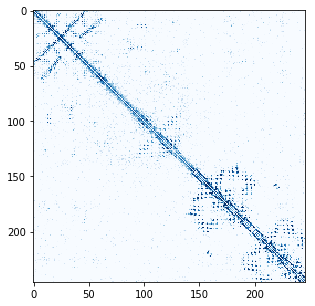

In [13]:
mtx = get_mtx(mrf)  
plot_mtx(mtx)

## Look at top co-evolving residue pairs

In [14]:
######################################################################################
# WARNING - WARNING - WARNING
######################################################################################
# - the i,j index starts at 0 (zero)
# - the "first" position = 0
# - often in biology first position of a sequence is 1
#   for this index use i_aa and j_aa!

# adding amino acid to index
mtx["i_aa"] = np.array([alphabet[msa['msa_ori'][0][i]]+"_"+str(i+1) for i in mtx["i"]])
mtx["j_aa"] = np.array([alphabet[msa['msa_ori'][0][j]]+"_"+str(j+1) for j in mtx["j"]])

# load mtx into pandas dataframe
pd_mtx = pd.DataFrame(mtx,columns=["i","j","apc","zscore","i_aa","j_aa"])

# get contacts with sequence seperation > 5
# sort by zscore, show top 10
top = pd_mtx.loc[pd_mtx['j'] - pd_mtx['i'] > 5].sort_values("zscore",ascending=False)
top.head(5)

,i,j,apc,zscore,i_aa,j_aa
29221,228,261,1.814831,3.137004,R_229,F_262
28431,213,221,1.788126,3.136720,L_214,R_222
25990,180,222,1.776078,3.136585,E_181,L_223
29512,236,244,1.772887,3.136549,A_237,R_245
29043,224,261,1.759905,3.136398,L_225,F_262


## Explore the MRF

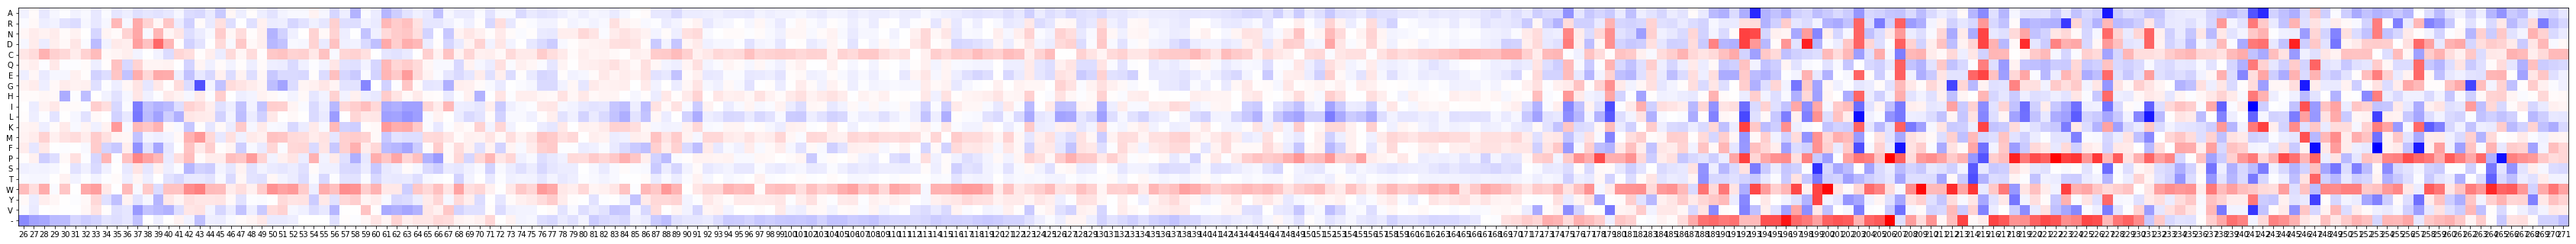

In [15]:
def plot_v(mrf):  
  al_a = list(alphabet)
  v = mrf["v"].T
  mx = np.max((v.max(),np.abs(v.min())))
  plt.figure(figsize=(v.shape[1]/4,states/4))
  plt.imshow(-v,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(v.shape[1]))
  plt.yticks(np.arange(0,21))
  plt.grid(False)
  ax = plt.gca()
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: mrf["v_idx"][x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  
plot_v(mrf)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


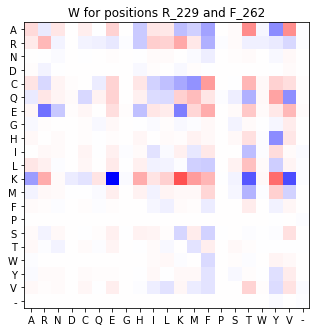

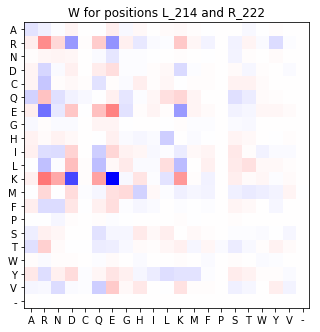

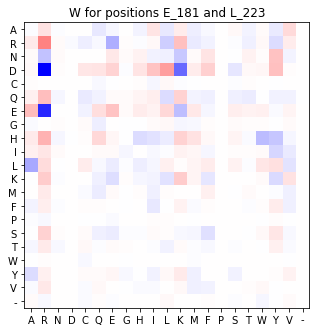

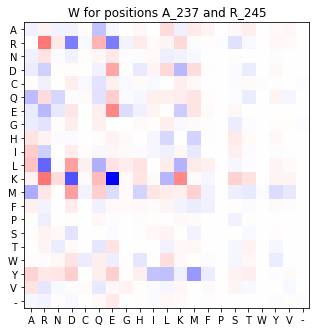

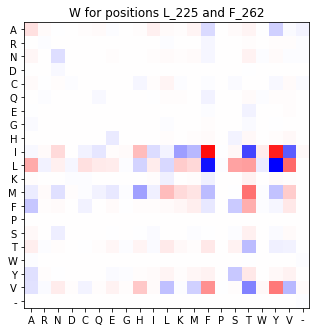

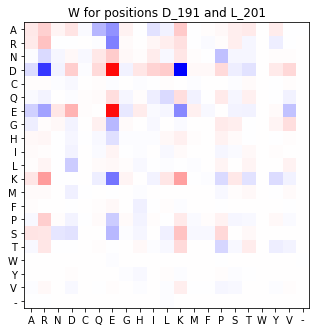

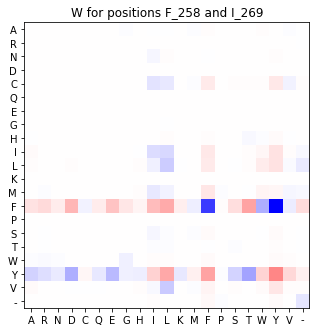

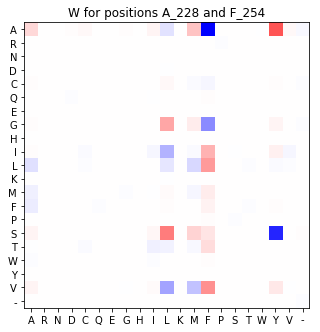

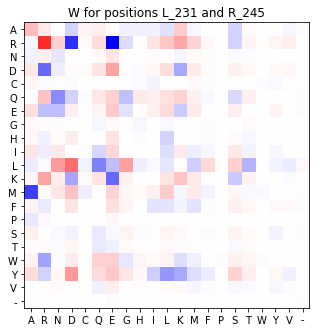

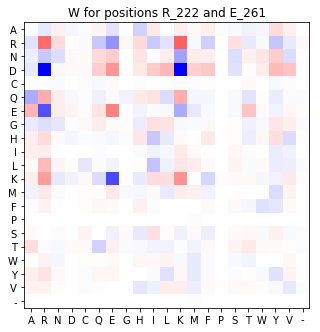

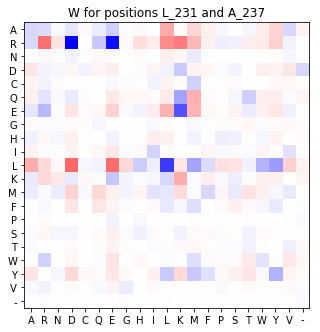

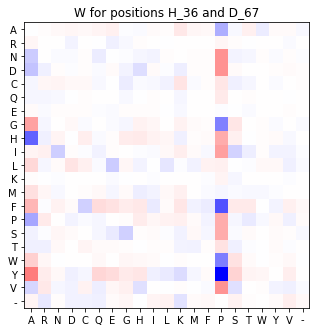

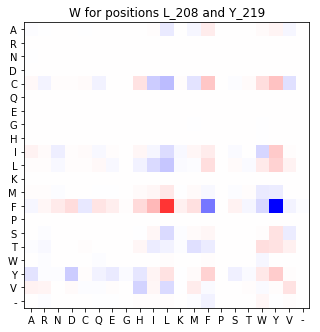

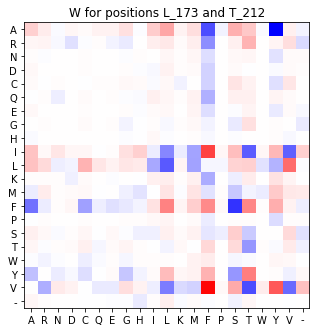

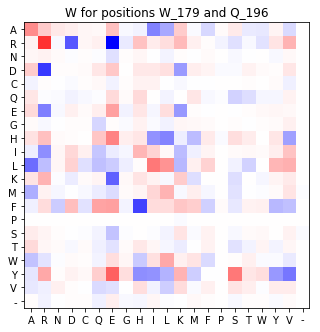

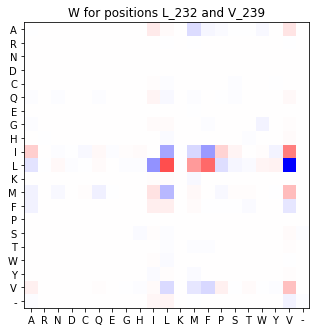

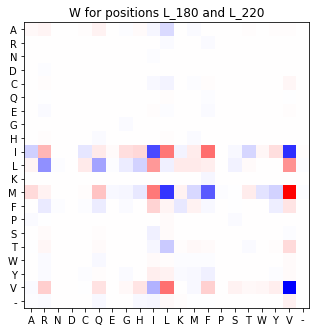

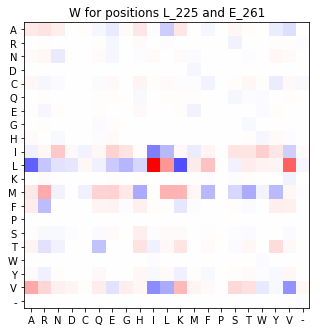

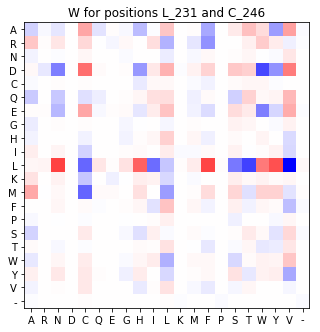

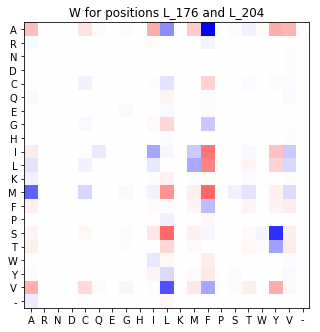

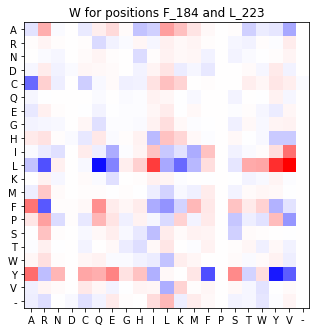

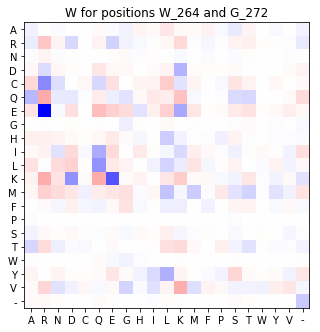

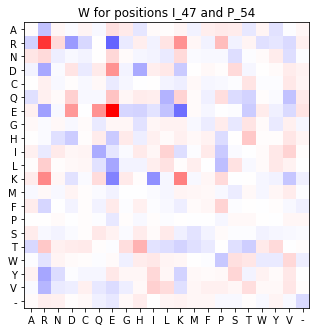

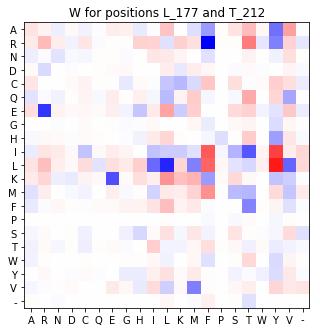

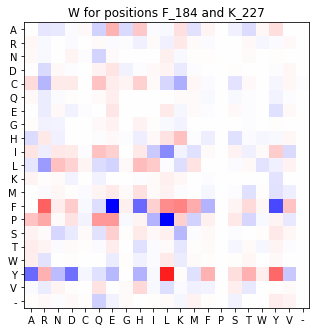

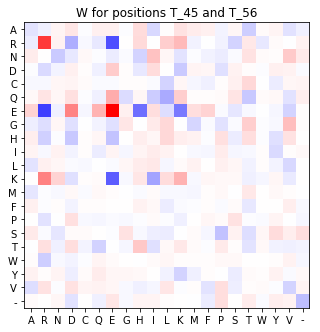

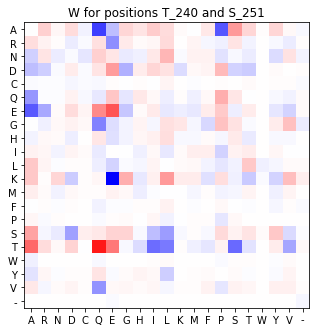

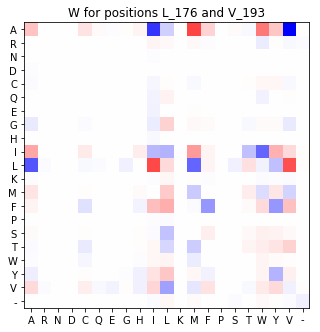

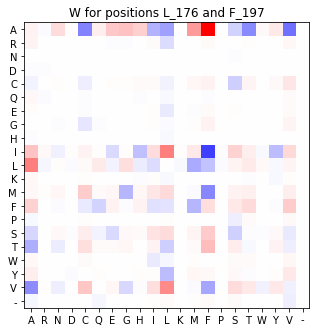

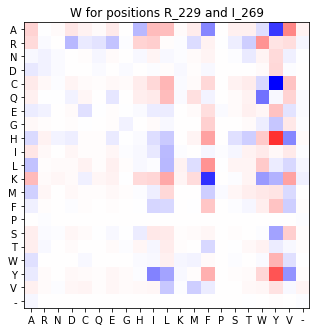

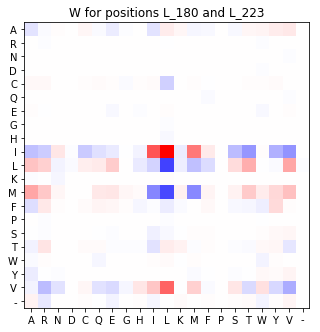

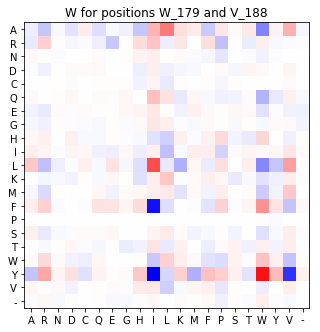

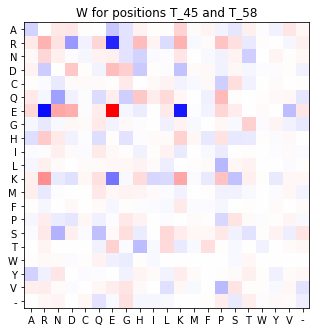

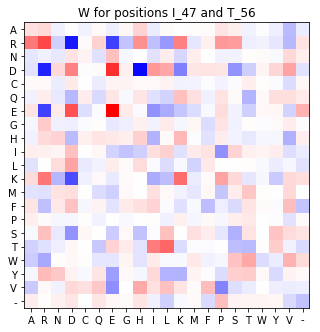

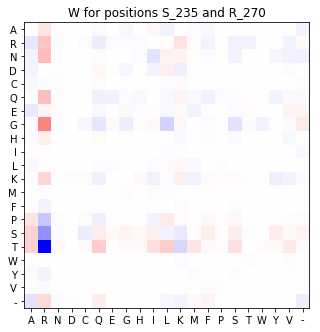

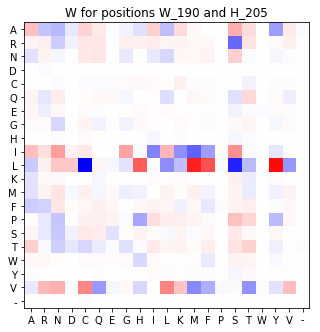

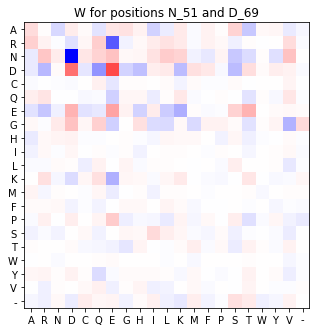

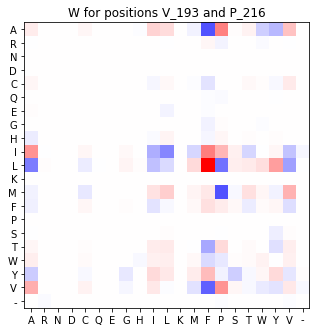

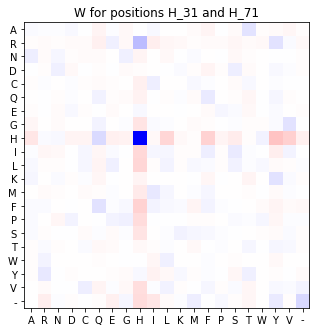

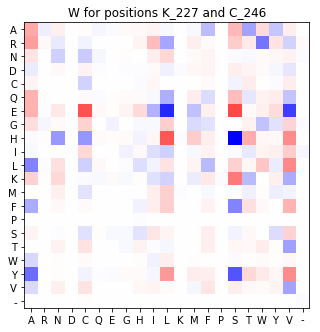

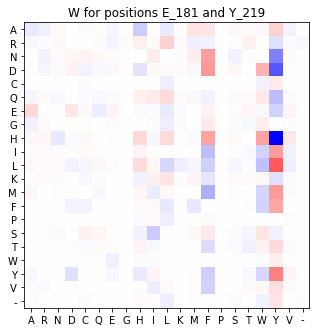

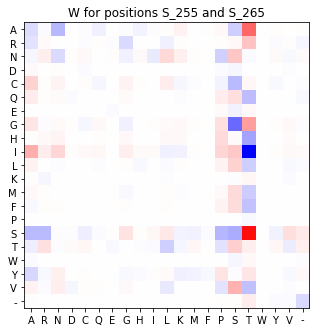

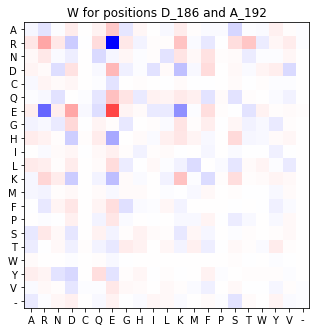

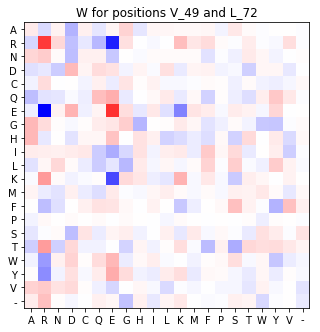

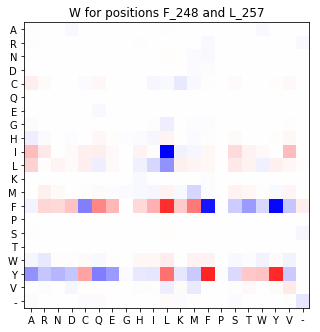

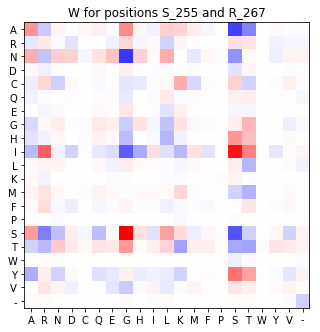

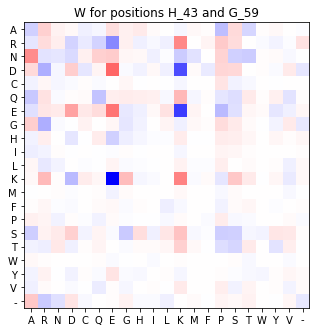

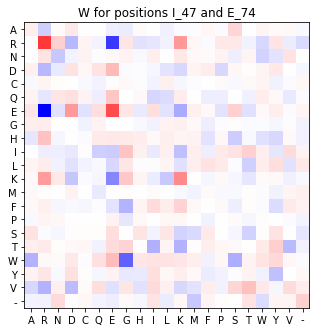

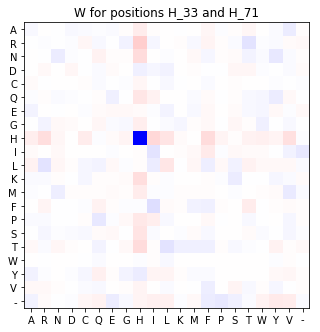

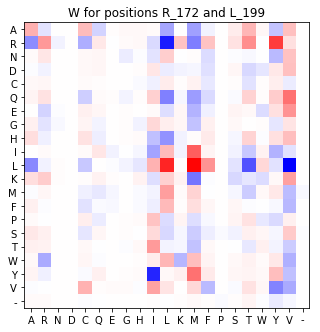

In [16]:
def plot_w(mrf,i,j,i_aa,j_aa):
  
  n = int(np.where((mrf["w_idx"][:,0] == i)&(mrf["w_idx"][:,1] == j))[0])
  w = mrf["w"][n]
  
  with open("W_for_positions_"+str(i_aa)+"_"+str(j_aa)+".csv",'w') as f:
    f.write(",")
    for k in alphabet:
        f.write(k+",")
    f.write("\n")
    dummy = 0
    for pos1 in w:
        f.write(alphabet[dummy]+",")
        for pos2 in pos1:
            f.write(str(round(pos2,2))+",")
        f.write("\n")
        dummy += 1
  mx = np.max((w.max(),np.abs(w.min())))
  plt.figure(figsize=(states/4,states/4))
  plt.imshow(-w,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(0,states))
  plt.yticks(np.arange(0,states))
  plt.grid(False)
  
  ax = plt.gca()
  al_a = list(alphabet)
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  plt.title(f"W for positions {i_aa} and {j_aa}")
  plt.savefig(f"W for positions {i_aa} and {j_aa}.png")
  #plt.show()

for n in range(50):
  i = int(top.iloc[n]["i"])
  j = int(top.iloc[n]["j"])
  i_aa = top.iloc[n]["i_aa"]
  j_aa = top.iloc[n]["j_aa"]
  plot_w(mrf,i,j,i_aa,j_aa)

## Useful input features for NN (Neural Networks)

The "apc" values are typically used as input to the NN for contact cleaning or structure prediction. Though in recent advances (aka DeepMind/Alphafold), the entire MRF was used as the input. More specificially LxLx442. The 442 channels are the 21x21 + (raw and/or apc) value.

In [17]:
w_out = np.zeros((msa["ncol_ori"],msa["ncol_ori"],442))
v_out = np.zeros((msa["ncol_ori"],21))

mrf_ = np.reshape(mrf["w"],(-1,441))
mtx_ = np.expand_dims(mtx["apc"],-1)

w_out[(mtx["i"],mtx["j"])] = np.concatenate((mrf_,mtx_),-1)
w_out += np.transpose(w_out,(1,0,2))
v_out[mrf["v_idx"]] = mrf["v"]

print("w_out",w_out.shape)
print("v_out",v_out.shape)

w_out (278, 278, 442)
v_out (278, 21)


In [18]:
!zip files.zip *png *csv *ipynb *fas

  adding: W for positions A_228 and F_254.png (deflated 11%)
  adding: W for positions A_237 and R_245.png (deflated 10%)
  adding: W for positions D_186 and A_192.png (deflated 9%)
  adding: W for positions D_191 and L_201.png (deflated 10%)
  adding: W for positions E_181 and L_223.png (deflated 9%)
  adding: W for positions E_181 and Y_219.png (deflated 10%)
  adding: W for positions F_184 and K_227.png (deflated 10%)
  adding: W for positions F_184 and L_223.png (deflated 10%)
  adding: W for positions F_248 and L_257.png (deflated 10%)
  adding: W for positions F_258 and I_269.png (deflated 11%)
  adding: W for positions H_31 and H_71.png (deflated 10%)
  adding: W for positions H_33 and H_71.png (deflated 9%)
  adding: W for positions H_36 and D_67.png (deflated 10%)
  adding: W for positions H_43 and G_59.png (deflated 11%)
  adding: W for positions I_47 and E_74.png (deflated 9%)
  adding: W for positions I_47 and P_54.png (deflated 9%)
  adding: W for positions I_47 and T_56.p

In [19]:
!rm *png *csv *fas